# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import date
import plotly.express as px
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from geopy.geocoders import Nominatim
from sklearn.compose import make_column_transformer
from ipywidgets import Dropdown, FloatSlider, IntSlider,interact

# Function to load and clean Data

In [41]:
#write a wrangle function to obtain data set
def wrangle(filename):
    #Load Data
    df=pd.read_csv(filename)
    
    #Drop nan values
    df.dropna(inplace=True)
    #Drop string value in price
    df=df.drop(df[df['Price']=="POA"].index)
    #Convert price to float
    df['Price']=df['Price'].astype(float)
    
    #Reset DataFrame Index
    df.reset_index(drop=True,inplace=True)
   
    #Create an empty list to hold the latitude and Longtitude
    maparea=[]
    #Obtain unique values of the address (this prevent us from obtain similar location data more than once)
    area=list(df['Location'].unique())
    #instantiate Nominatim class
    geolocator=Nominatim(user_agent = "my_locator")
    #obtain location data and append in the list maparea
    for i in range(len(area)):
        loc=geolocator.geocode(f"{area[i]}",timeout=20)
        maparea.append((loc.latitude, loc.longitude))
    #Populate the Data with the location data i.e., geocode
    df['lat'], df['lon']=(0,0)
    
    for i in df.index:
        df['lat'].iloc[i],df['lon'].iloc[i]=(maparea[area.index(df['Location'].iloc[i])][0],
                             maparea[area.index(df['Location'].iloc[i])][1])
    
    #Splitting Location to City and State
    df['City']=df['Location'].str.split(',',expand=True)[0]
    df['State']=df['Location'].str.split(',',expand=True)[1]
    
    #Convert Seat string to float
    df['Seats']=df['Seats'].str.replace(' Seats','').str.replace(' ','').astype(float).round()
    
    #Convert Door string to float
    df['Doors']=df['Doors'].str.replace(' Doors','').str.replace(' ','').astype(float).round()
    
    #Convert Cylinder Engine to float
    df['CylindersinEngine']=(df['CylindersinEngine']
                             .str.replace(' L','')
                             .str.replace(' cyl','')
                             .astype(float)).round()
    
    #obtain Engine Capacity
    df['Engine']= (df['Engine']
                     .str.split(',',expand=True)[1]
                     .str.replace(' L','')
                     .astype(float)
                     .fillna(0)).round(1)
    
    #Obtain the age of the car
    df['Age(years)']=(date.today().year-df['Year']).round(2)
    
    #Convert Fuel consumption per 100 km to Fuel consumption to km
    df['FuelperKm']=(df['FuelConsumption']
                     .str.split(' / ', expand=True)[0]
                     .str.replace(' L','')
                     .astype(float).div(100)).round(3)
    
    #Convert kilometres column to float
    df['Kilometres']= (df['Kilometres']
                       .replace('-','0')
                       .astype(float).round())
    
    #Obtain Exterior colours
    df['ColourExtInt']= df['ColourExtInt'].str.split(' / ', expand=True)[0]
    for column in df.select_dtypes('object').columns:
        mask=(df[column].value_counts()[df[column].value_counts()<5])
        feat=[names for names,value in mask.items()]
        for name in feat:
            df=df.drop(df[df[column]==name].index, axis=0)
   
    #df['State']=df['State'].map({ ' NSW':'New South Wales', 
                                                    #' VIC':'Victoria',
                                                    #' QLD':'Queensland',
                                                    #' SA':'South Australia',
                                                    #' WA':'Western Australia',
                                                    #' ACT': 'Australia Capital Territory',
                                                    #' AU-VIC':'Victoria',
                                                    #' TAS':'Tasmania',
                                                    #' NT':'Northern Territory'})
    #df.drop(['Location'],axis=1,inplace=True)
    #df["Country"]="Australia"
    
    # Drop column with high cardinality and duplicate column 
    #High Cardinal Column
    Columnhead=list(
                    df.select_dtypes(exclude='number').columns
                    [df.select_dtypes(exclude='number').nunique()>70]
                   )
    #Duplicate Column
    Columnhead.append('Year')
    #Add relevant High Cardinal Column
    Columnhead.remove('City')
    
    df.drop(columns=Columnhead,axis=1,inplace=True)
    #Reset DataFrame Index
    df.reset_index(drop=True,inplace=True)
    
    
    return df

# Implement Function in Loading and Cleaning Data

In [42]:
Data=wrangle('Downloads/Australian Vehicle Prices.csv')
Data.head()

/var/folders/1p/qxfwymf91bx8xq63_r1658sm0000gn/T/ipykernel_12841/1827460122.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Brand,Car/Suv,UsedOrNew,Transmission,Engine,DriveType,FuelType,Kilometres,ColourExtInt,CylindersinEngine,BodyType,Doors,Seats,Price,lat,lon,City,State,Age(years),FuelperKm
0,MG,Hatchback,USED,Automatic,1.5,Front,Premium,16.0,Black,4.0,Hatchback,5.0,5.0,19990.0,-33.762885,151.270702,Brookvale,NSW,2.0,0.067
1,Toyota,Commercial,USED,Automatic,3.0,Rear,Diesel,229829.0,White,4.0,Commercial,4.0,2.0,27995.0,-33.863815,151.045243,Lidcombe,NSW,8.0,0.080
2,Nissan,SUV,USED,Automatic,2.0,Front,Unleaded,114301.0,Blue,4.0,SUV,4.0,5.0,21950.0,-31.654036,152.291893,Pendle Hill,NSW,6.0,0.069
3,Ford,Hatchback,USED,Automatic,1.5,Front,Unleaded,94965.0,White,4.0,Hatchback,5.0,5.0,16999.0,-33.740189,150.864836,Blacktown,NSW,8.0,0.062
4,Nissan,SUV,USED,Automatic,2.5,Front,Unleaded,99294.0,Grey,4.0,SUV,4.0,7.0,24490.0,-33.740189,150.864836,Blacktown,NSW,5.0,0.081


# Data Exploration and Visualization

# Mean Price Brand

In [43]:
mBrand_Price=Data.groupby('Brand')['Price'].mean().round(2)
mBrand_Price

Brand
Audi             54006.86
BMW              44354.85
Chrysler         61711.20
Ford             36720.75
GWM              40123.99
Holden           21967.55
Honda            28134.07
Hyundai          23784.28
Isuzu            32496.03
Jeep             28140.08
Kia              29154.89
LDV              30789.80
Land             51174.83
MG               30029.59
Mazda            28033.22
Mercedes-Benz    52616.60
Mitsubishi       30029.09
Nissan           24137.53
Renault          39489.95
Ssangyong        50030.45
Subaru           33917.63
Suzuki           25288.14
Toyota           41222.41
Volkswagen       40739.53
Name: Price, dtype: float64

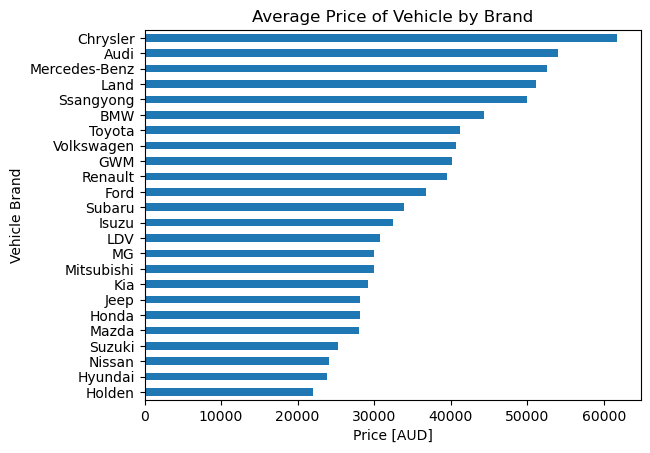

In [44]:
mBrand_Price.sort_values().plot(kind='barh')
plt.xlabel('Price [AUD]')
plt.ylabel('Vehicle Brand')
plt.title('Average Price of Vehicle by Brand');

# Histogram Plot of Vehicle Prices

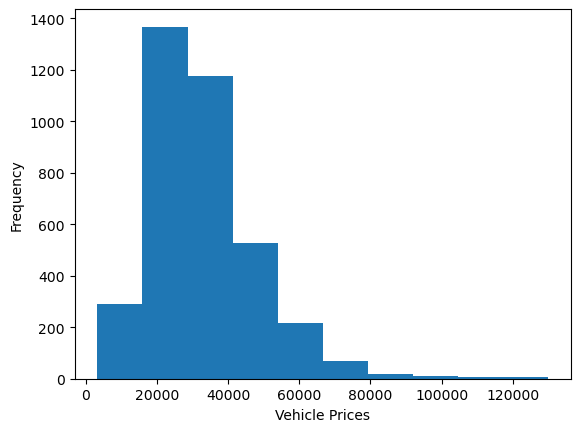

In [46]:
Data['Price'].plot(kind='hist')
plt.xlabel('Vehicle Prices');

# Detecting Outlier

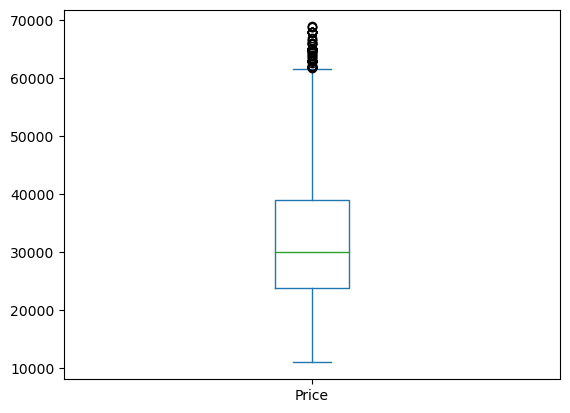

In [66]:
Data['Price'].plot(kind='box');

# Removing Outliers

In [27]:
low,high=Data['Price'].quantile([0.025,0.975])
low,high

(10999.0, 68888.0)

In [51]:
Data=Data[Data['Price'].between(low,high)]

# Mean Brand Price excluding Outlier

In [52]:
mBrand_Price2=Data.groupby('Brand')['Price'].mean().round(2)
mBrand_Price2

Brand
Audi             54006.86
BMW              44354.85
Chrysler         58417.00
Ford             37448.77
GWM              40123.99
Holden           23740.11
Honda            35390.00
Hyundai          24166.05
Isuzu            32496.03
Jeep             28140.08
Kia              29214.06
LDV              30789.80
Land             36169.18
MG               30029.59
Mazda            28856.70
Mercedes-Benz    46410.10
Mitsubishi       30029.09
Nissan           24882.35
Renault          34326.34
Ssangyong        50030.45
Subaru           34177.40
Suzuki           25288.14
Toyota           37917.45
Volkswagen       40739.53
Name: Price, dtype: float64

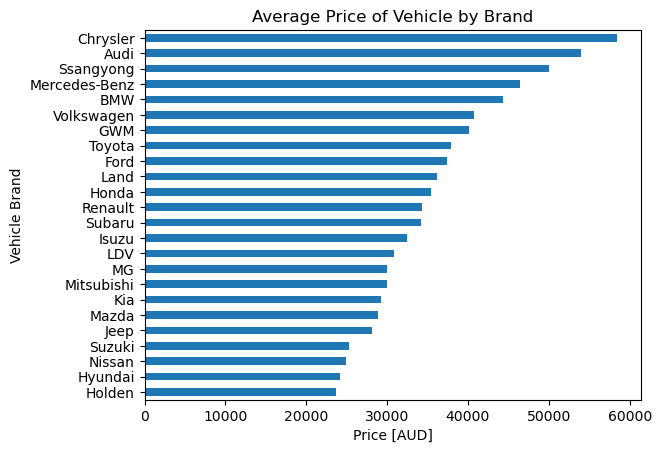

In [53]:
mBrand_Price2.sort_values().plot(kind='barh')
plt.xlabel('Price [AUD]')
plt.ylabel('Vehicle Brand')
plt.title('Average Price of Vehicle by Brand');

# Histogram Plot of Price

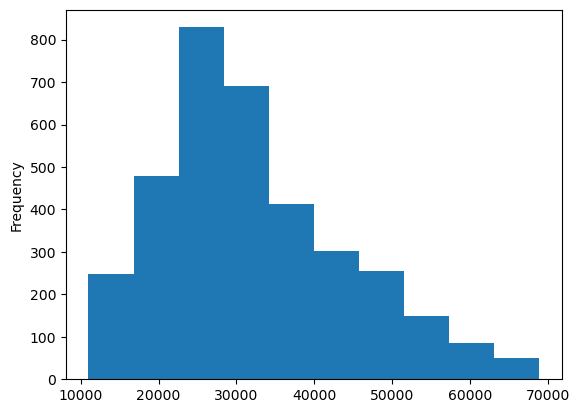

In [54]:
Data['Price'].plot(kind='hist');

<AxesSubplot:>

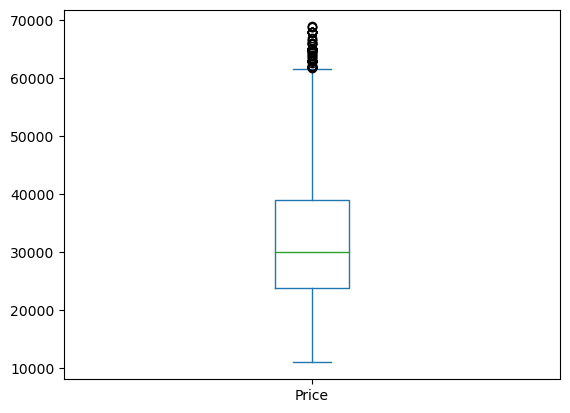

In [63]:
Data['Price'].plot(kind='box')

# mapbox plot of Data

In [55]:
fig=px.scatter_mapbox(Data,
                  lat='lat',
                  lon='lon',
                width=900,
                 height=600,
                 center={'lat':Data['lat'].mean(), 'lon':Data['lon'].mean()},
                  color='Price',
                  hover_data=['Price'],
                      hover_name='Brand'
                 )
fig.update_layout(mapbox_style='open-street-map')
fig.show()

# Proportion of Vehicle in each  City 

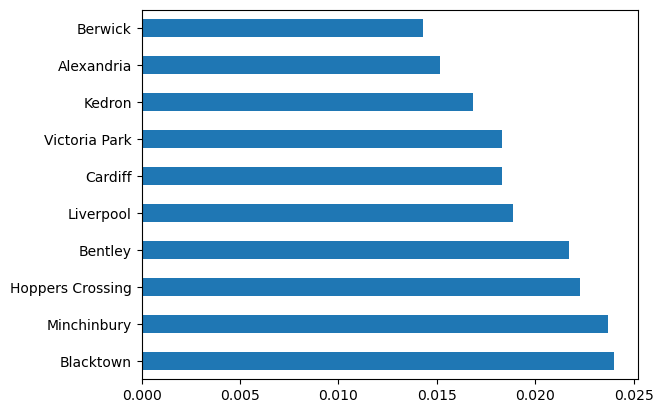

In [37]:
Data['City'].value_counts(normalize=True).head(10).plot(kind='barh');

# Scatter Plot: Price vs Distance

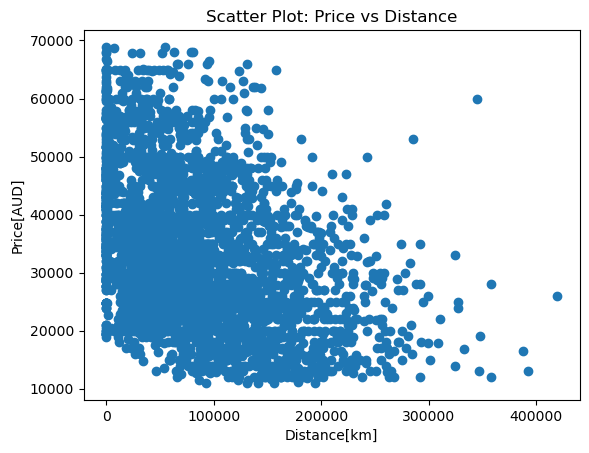

In [56]:
plt.scatter(x=Data['Kilometres'],y=Data['Price'])
plt.xlabel('Distance[km]')
plt.ylabel('Price[AUD]')
plt.title('Scatter Plot: Price vs Distance');

In [57]:
K_correlation=Data['Price'].corr(Data['Kilometres'])
K_correlation

-0.36145882911331334

# Scatter Plot: Price vs Age

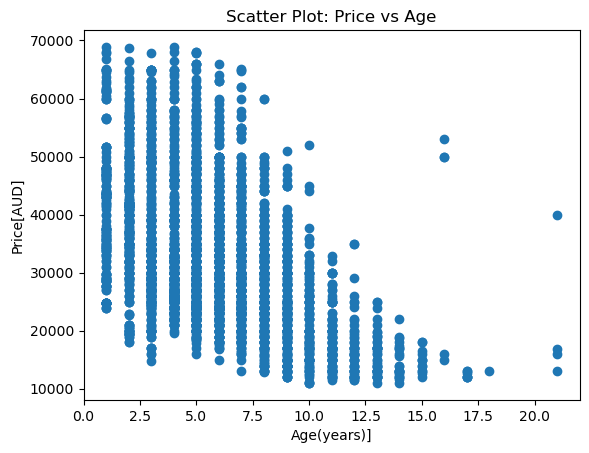

In [58]:
plt.scatter(x=Data['Age(years)'],y=(Data['Price']))
plt.xlabel('Age(years)]')
plt.ylabel('Price[AUD]')
plt.title('Scatter Plot: Price vs Age');

# Correlation Chart

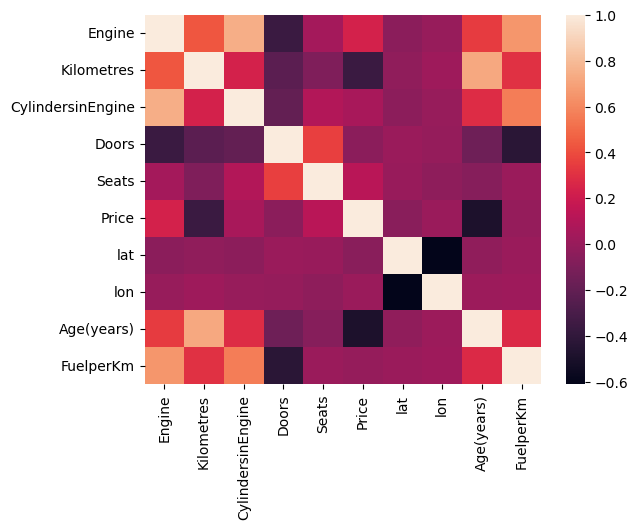

In [62]:
corr=Data.select_dtypes('number').corr()
sns.heatmap(corr);